In [26]:
#%pylab inline
# para ver gráficas en ventanas emergentes usar borrar "inline" de la línea anterior
#pylab.rcParams['figure.figsize'] = (10, 6)
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
from scipy import optimize
import seaborn as sb

## Funciones para simular un Canal Inalámbrico

In [27]:
def genScat(Ns,Rc,Cc):
    """ FUNCTION genScat(Ns, Rc, Cc)
    Esta funcion devuelve un arreglo de Ns x 2. Cada fila representa la posicion
    (x,y) de un reflector en el plano. Estos reflectores estan distribuidos
    de un modo aleatorio uniforme adentro de circulos con radios dados por el 
    vector Rc (radios de los clusters) y dentro de cada cluster hay una cantidad
    de reflectores dadas por el vector Ns de cantidades de reflectores por cluster.
    Cc es un arreglo con una cantidad de filas igual a la cantidad de clusters
    y cuyas filas son las posiciones (x,y) del centro de los clusters.
    Ejemplo:
    --------
    Ns = [20, 20, 20];  
    Rc = [20, 20, 20];  
    Cc = [100,0.0 ; 300,0.0 ; 500,0.0];
    genScat(Ns,Rc,Cc) en este caso genera 20 reflectores al azar agrupados en 
    3 clusters de 20 metros de diametro centrados en (100,0), (300,0) y (500,0).
    ¿Rc ES DIAMETRO O RADIO?
    """
    S = np.empty((sum(Ns),2))
    Nsum = [int(sum(Ns[:i])) for i in range(len(Ns)+1)]
    for i in range(len(Nsum)-1):
        S[Nsum[i]:Nsum[i+1],:] = genClust(Ns[i])*Rc[i]+np.repeat([Cc[i,:]],Ns[i], axis=0)
    return S


def genClust(N):
    """ genClust(N)
    Genera un cluster de N posiciones uniformemente distribuidas en un
    círculo de diámetro unitario. Retorna un arreglo de N x 2 adonde cada
    fila es una posición (x,y)
    """
    Clust = np.empty((N,2))
    n = 0
    while n < N:
        X = np.random.rand(2)-np.array([0.5,0.5])
        if X.dot(X) < 0.25:
            Clust[n,:]=X
            n = n + 1
    return Clust


def genDists(S, posTx, posRx):
    """ genDists(S,posTx,posRx)
    Recibe un arreglo de N x 2 adonde cada fila describe la
    posicion (x,y) de N reflectores y retorna un arreglo Dsts con N distancias entre
    posTx y posRx (vectores (x,y) que describen posiciones de Tx y Rx)
    medidas como rectas que unen los puntos Tx, reflector y Rx.
    Tambien se retorna un arreglo D_ref_Rx con las N distancias entre reflector
    y Rx.
    Por convencion todas las distancias son en metros. 
    """

    Dsts = np.empty(S.shape[0])
    D_ref_Rx = np.empty(S.shape[0])
    for i in range(len(Dsts)):
        a = posTx - S[i,:]
        b = posRx - S[i,:]
        Dsts[i] = np.sqrt(a.dot(a)) + np.sqrt(b.dot(b))
        D_ref_Rx[i] = np.sqrt(b.dot(b))
    return Dsts, D_ref_Rx


def genhl(Dsts, fc, W, a_i, oversample=1, margen=0):

    """ genhl(Dsts, fc, W, a_i, oversample, margen)
    Esta funcion produce la respuesta impulsiva discreta equivalente banda base 
    del canal correspondiente a todos los caminos con distancias dadas por el 
    vector Dsts, una frecuencia central fc, un ancho de banda W, atenuaciones 
    a_i (tambien un vector con las atenuaciones de cada camino).
    oversample es un parametro que debe ser un nro entero mayor o igual a 1 y 
    que sirve para generar puntos intermedios entre las muestras (para simular 
    el comportamiento "analogico" del canal)
    margen: la respuesta se calcula para floor(margen)/2 muestras anteriores al
    primer eco (o camino) recibido del canal e idem para el ultimo recibido. 
    """

    if ((oversample-np.floor(oversample))!=0) | (oversample<1):
        raise ValueError('El parametro oversample debe ser un entero mayor o igual a 1.')

    c = 3e8                # m/s
    Rts = Dsts/c           # retardos
    GroupRet = min(Rts)
    Td = max(Rts)-GroupRet # delay spread

    RtsRel = Rts - GroupRet

    hl = np.empty(int(np.floor(Td*W*oversample)+margen*oversample+1),dtype='complex128')  
                                                        # h_l con l=0,1,...,floor(Td*W*oversample)+margen
    a_ib = a_i * np.exp(-1j*2*np.pi*fc*Rts)
    for l in range(len(hl)):
        hl[l] = (np.sinc(l/oversample - np.floor(margen/2) - RtsRel*W)).dot(a_ib.T)
    tt = np.arange(len(hl))/W/oversample - np.floor(margen/2)/W + GroupRet
    
    return hl, tt


def delaySpread(Dsts):
    """ delaySpread(Dsts)
    Recibe como parametro un vector Dsts de distancias (en metros)
    y retorna el delay spread Td (en segundos) entre esas distancias.
    """ 
    Rts = Dsts/3e8
    return max(Rts)-min(Rts)

## Funciones mías

In [28]:
def rayleigh(x, v):
    return (x/v)*np.exp(-0.5*x**2/v)

def rician2(x, m):
    return x*np.exp(-0.5*(x**2+m**2))*np.i0(x*m)

def rician(x, m, v):
    return (x/v)*np.exp(-0.5*(x**2+m**2)/v)*np.i0(x*m/v)

def pos_max(a):
    max = np.max(a)
    for i in range(np.size(a)):
        if (a[i] == max):
            i_max = i
    return i_max

def pos_min(a):
    min = np.min(a)
    for i in range(np.size(a)):
        if (a[i] == min):
            i_min = i
    return i_min

def shift(x, n):
    """shiftear n posiciones el vector x, asignando 0 a las primeras n posiciones del vector"""
    x = np.roll(x,n)
    for i in range(n):
        x[i] = 0
    return x

### Ejemplo 2

Tres "clusters" con 20 reflectores cada uno

In [29]:
Ns=np.array([500])  #nro. de reflectores por cluster
Nref = np.sum(Ns)   #cantidad de clusters (caminos) totales
Rc=np.array([50]) #diametro de los clusters en metros
Cc=np.array([[0,50.0]]) #centros de los clusters
posTx = np.array([0,0])
posRx = np.array([0.0,50.0])
fc = 1e9 # [Hz]
c = 300e6 # [m/s ]
vmax = 60000/3600 # [m/s]

In [30]:
# generamos "clusters"
S = genScat(Ns,Rc,Cc)
Dsts,DstsRx = genDists(S,posTx,posRx)
d_Clarke = (Dsts - DstsRx) * DstsRx    #d1*d2
a_i = -1*np.ones(np.size(Dsts))/d_Clarke


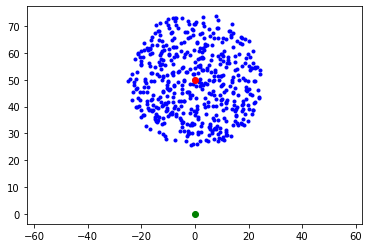

In [31]:
for s in S:
    plt.plot(s[0],s[1],'b.')
plt.plot(posTx[0],posTx[1],'go')
plt.plot(posRx[0],posRx[1],'ro')
plt.xlim(130,170)
plt.axis('equal')
plt.show()

### Consigna 1
Proponga tres anchos de banda W1 < W2 < W3 tales que (i) toda la información del canal
esté concentrada en un único “tap”, (ii) que el sistema E/S pueda resolver los clusters
pero no los caminos que los conforman y (iii) que el sistema E/S pueda resolver buena
parte de los caminos (i.e., que distinga, sino todos, buena parte de los caminos que surgen
de cada cluster). ¿A qué clasificación corresponden estos casos? Muestre gr´aficos de la
respuesta temporal y frecuencial para cada caso. Estime anchos de banda de coherencia y
relaci ´onelos con W1, W2 y W3.

In [32]:
# generamos 2 respuestas impulsivas (para diferentes anchos de banda)
# ha_i --> rtas "analógica" (emulada usando oversample de 10 veces)
# hd_i --> rtas digitales (sin oversample)
# ta_i y td_i son los instantes de tiempo para cada valor de la respuesta
margen = 15
oversample = 20
#ha_1, ta_1 = genhl(Dsts, fc, 20/delaySpread(Dsts),a_i, oversample, margen)
#hd_1, td_1 = genhl(Dsts, fc, 20/delaySpread(Dsts),a_i, 1, margen)
#ha_2, ta_2=genhl(Dsts, fc, 200.0/delaySpread(Dsts),a_i, oversample, margen)
#hd_2, td_2=genhl(Dsts, fc, 200.0/delaySpread(Dsts),a_i, 1, margen)
w1 = 30e3
ha_1, ta_1 = genhl(Dsts, fc, w1, a_i, oversample, margen)
hd_1, td_1 = genhl(Dsts, fc, w1, a_i, 1, margen)



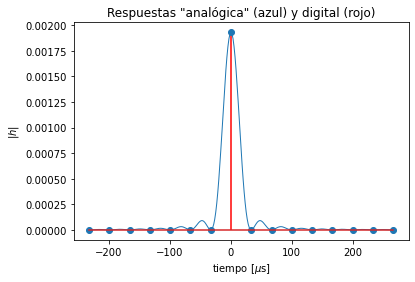

In [33]:
plt.plot(ta_1*1e6,abs(ha_1)**2,linewidth=1)
plt.stem(td_1*1e6,abs(hd_1)**2,'r', use_line_collection = True)
plt.xlabel('tiempo [$\mu$s]')
plt.ylabel('$|h|$')
plt.title('Respuestas "analógica" (azul) y digital (rojo)')
plt.show()


### Consigna 4



In [43]:
v = 2                       #m/s
d_coh = 0.13                #metros (de heatmap 1x1)
x_ini = -22                 #metros
x_fin = 22                  #metros
dt = 0.1*d_coh/v            #pasos de d_coh/10 [m]
T = (x_fin - x_ini)/v       #tiempo total
N = int(T/dt)               #cant de pasos
t = np.linspace(0, T, N)    #vector de tiempos
xRx = x_ini + v*t           #vector de posiciones



tap4 = np.zeros(len(xRx), dtype= complex)


for i in range(len(xRx)):
    posRx = np.array([xRx[i],30.0])
    Dsts,DstsRx = genDists(S,posTx,posRx)
    d_Clarke = (Dsts - DstsRx) * DstsRx    #d1*d2
    a_i = -1*np.ones(np.size(Dsts))/d_Clarke
    hd_4, td_4 = genhl(Dsts, fc, w1, a_i, 1, margen)
    i_max = pos_max(abs(hd_4))
    tap4[i] = hd_4[i_max]




(-1000.0, 1000.0)

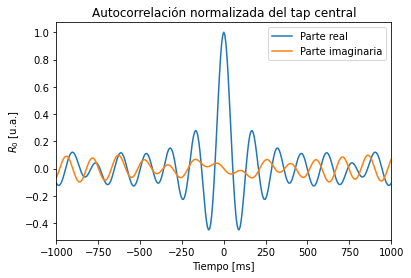

In [44]:
K = int(N/2)
k = np.linspace(-K, K-1, 2*K, dtype=int)
autocorr = np.zeros(2*K, dtype=complex)

for i in k:
    if (i<0):
        tap4_shift = shift(tap4, -i)
        autocorr[i] = np.vdot(tap4_shift, tap4)/(N+i)
    else:
        tap4_shift = shift(tap4, i)
        autocorr[i] = np.vdot(tap4, tap4_shift)/(N-i)
    

autocorr = autocorr/max(abs(autocorr))


plt.plot(k*dt*1e3,fft.fftshift(autocorr.real), label = "Parte real") #k[i] != i, un índice negativo cuenta desde el último elemento para atrás
plt.plot(k*dt*1e3,fft.fftshift(autocorr.imag), label = "Parte imaginaria") #por lo tanto, autocorr no quedó ordenado como k, por eso lo shifteo
#plt.plot(k*dt*1e3,fft.fftshift(abs(autocorr)))
plt.xlabel("Tiempo [ms]")
plt.ylabel("$R_0$ [u.a.]")
plt.legend()
plt.title("Autocorrelación normalizada del tap central")
plt.xlim(-1000,1000)

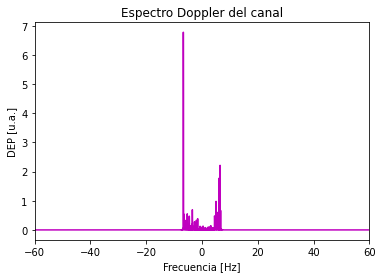

In [45]:
fs = 1/(t[1] - t[0])

f = np.linspace(-fs/2,fs/2, np.size(t), endpoint=False)


dep = fft.fftshift(fft.fft(autocorr, norm="ortho"))
#dep = fft.fft(np.ones(len(f)), norm="ortho")

plt.plot(f, abs(dep)**2, color = 'm')
#plt.xlim(-0.05,0.05)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("DEP [u.a.]")
plt.title("Espectro Doppler del canal")
plt.xlim(-60,60)
plt.show()